# World Development Indicators

This dataset contains the World Development Indicators from the World Bank, indicators measured annually to assess economic development from hundreds of countries around the world.

As the data comes as a SQLite database, I felt it would provide a good opportunity to practice and further:

- the SQL I have been learning recently,
- data manipulation and transformation using SQL alongside pandas,
- Matplotlib/Seaborn to create interesting data visualisations - I recently discovered this incredible resource showing methods of presenting different types of data and am looking forward to implementing some of these: https://public.tableau.com/profile/andy.kriebel#!/vizhome/VisualVocabulary/VisualVocabulary

Dataset sourced from Kaggle: https://www.kaggle.com/worldbank/world-development-indicators/version/2

#### Importing the necessary libraries

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
sns.set_style('whitegrid')
palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.70),
 (1.0, 0.4980392156862745, 0.054901960784313725,0.70),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.70),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392,0.70),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353,0.70),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902,0.70),                                  
 (0.1, 0.1, 0.1,0.70)]
sns.set_palette(palette)
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 13

#### Selecting a colour palette - as we're looking at categorical data I am selecting a palette with distinct colours

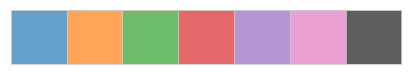

In [22]:
sns.palplot(palette)

#### Connecting to SQLite DB
I could use the inbuilt cursor feature of the sqlite3 library to interact with the database but it is a little clunky, requiring for loops and printing the results of the query in a fairly unreadable format (one large string). I'll instead use Pandas' inbuilt read_sql() function to run queries as it outputs the data in a much nicer format.

In [4]:
#Connecting to DB
conn = sqlite3.connect("C:\Databases\World Development Indicators\database.sqlite")

In [4]:
#Investigating the format of our features and observations
pd.read_sql(
    """
    PRAGMA table_info(indicators)
    """,
    con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CountryName,TEXT,0,None,0
1,1,CountryCode,TEXT,0,None,0
2,2,IndicatorName,TEXT,0,None,0
3,3,IndicatorCode,TEXT,0,None,0
4,4,Year,INTEGER,0,None,0
5,5,Value,NUMERIC,0,None,0


In [5]:
#6 features, how many rows?
pd.read_sql(
    """
    SELECT MAX(rowid) FROM indicators
    """,
    con=conn)

,MAX(rowid)
0,5656458


In [6]:
#In the indicators table, there are 5.66m rows containing data from 1300+ indicators.
#I'm going to export the unique indicators to a CSV for manual review of which to investigate.
pd.read_sql(
    """
    SELECT DISTINCT IndicatorCode, IndicatorName
    FROM indicators
    """,
    con=conn).to_csv('Indicator List.csv')

Discussion and analysis

## 1) How have CO2 emissions changed over the last 4 decades? Are there any increases or decreases in particular areas or industries?

As we're following trends over time for individual economic areas I am going to use a lineplot to clearly display the information.

Creating our subset of the data, selecting appropriate indicators and these regions of the globe: 
- East Asia & Pacific
- European Union
- Latin America & Caribbean
- North America
- Middle East & North Africa
- Sub-Saharan Africa
- World

In [14]:
atmosphere = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
            'EN.ATM.CO2E.PC',
            'EN.CO2.BLDG.ZS',
            'EN.CO2.ETOT.ZS',
            'EN.CO2.MANF.ZS',
            'EN.CO2.TRAN.ZS',
            'EN.ATM.METH.EG.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [15]:
#Seperating our atmosphere dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
atmosphere_dict = {}
for i in atmosphere.IndicatorCode.unique():
    atmosphere_dict[i] = atmosphere[atmosphere.IndicatorCode == i]

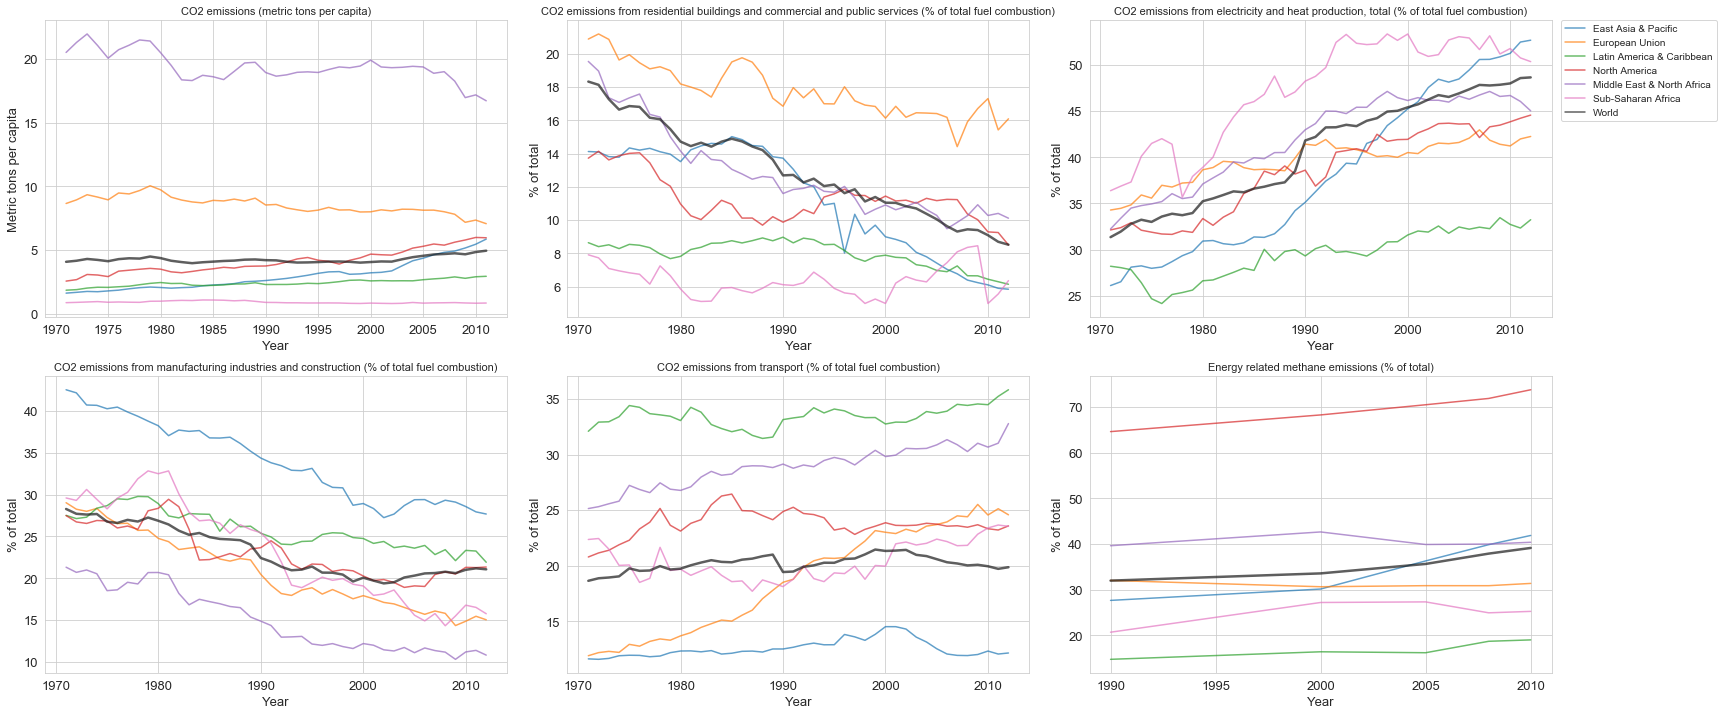

In [389]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in atmosphere.IndicatorCode.unique():
    ind +=1
    #Plotting the data
    sns.lineplot(x='Year',y='Value',hue='CountryName',data=atmosphere_dict[i],ax=axes[int((1/3)*ind)][ind-3],palette=palette)
    #Pulling title from IndicatorName field
    axes[int((1/3)*ind)][ind-3].set_title(str(atmosphere_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
    #Removing legend to allow for a single common legend
    axes[int((1/3)*ind)][ind-3].get_legend().remove()
    #Setting y labels for graphs
    axes[int((1/3)*ind)][ind-3].set_ylabel('% of total')
    #Making the line for World value bolder to allow easy identification of global direction on indicator
    plt.setp(axes[int((1/3)*ind)][ind-3].lines[6],linewidth=2.5)
        
#Creating patches for labels
handles, labels = axes[0][2].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Setting legend position on graph
axes[0][2].legend(handles,labels,bbox_to_anchor=(1.01, 1.017))
#Setting unique y label values
axes[0][0].set_ylabel('Metric tons per capita')
#Setting x ticks to avoid half-year values
axes[1][2].set_xticks(range(1990,2015,5))
#Setting y ticks to prevent running in to title
axes[0][1].set_yticks(range(6,22,2))
plt.show()

For the first piece of investigative analysis I wanted to keep things fairly straightforward as I familiarised myself with the dataset. I feel that the linegraphs here work well to show the trends in CO2 emissions over time, and it's interesting to see how on the whole the globe roughly follows the same trends with each emissions area.

It would be nice for some data to be included for 2016/2017 as well to see if the Paris Climate agreement signed in 2015 had an appreciable impact. It's interesting to see how we are reducing our CO2 emissions from our homes, offices, and industries, but increasing them in the electricity market as our demand on this sector increases. I think that the relatively flat level for transport reflects how there has not been a huge amount of innovation in this sector for the last few decades.

## 2) How has the distribution of age and where people live changed?

As this dataset is fairly simple, I want to present it in a simple and easy to interpret manner, using a stackplot. This allows you to easily see how the proportion of the categories has changed over time and presents the trends in a clear manner.

In order to graph it in a stackplot I need to rearrange the data in to two seperate arrays, a 3 x N array for the age graph and 2 x N array for the location graph.

In [382]:
#Creating our dataframe
popspread = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SP.POP.0014.TO.ZS',
        'SP.POP.1564.TO.ZS',
        'SP.POP.65UP.TO.ZS',
        'SP.RUR.TOTL.ZS',
        'SP.URB.TOTL.IN.ZS') AND 
        CountryCode IN ('WLD') 
        
    
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [383]:
#Creating our 3 x N array for the stackplot using list comprehension and np.vstack operation
yage = np.vstack([[popspread[popspread['IndicatorCode']==i]['Value']] for i in ['SP.POP.0014.TO.ZS','SP.POP.1564.TO.ZS','SP.POP.65UP.TO.ZS']])
#Creating our x values for year
xage = popspread[popspread['IndicatorCode']=='SP.POP.0014.TO.ZS']['Year']

#Creating our 2 x N array for the stackplot using list comprehension and np.vstack operation
yloc = np.vstack([[popspread[popspread['IndicatorCode']==i]['Value']] for i in ['SP.RUR.TOTL.ZS','SP.URB.TOTL.IN.ZS']])
#Creating our x values for year
xloc = popspread[popspread['IndicatorCode']=='SP.URB.TOTL.IN.ZS']['Year']

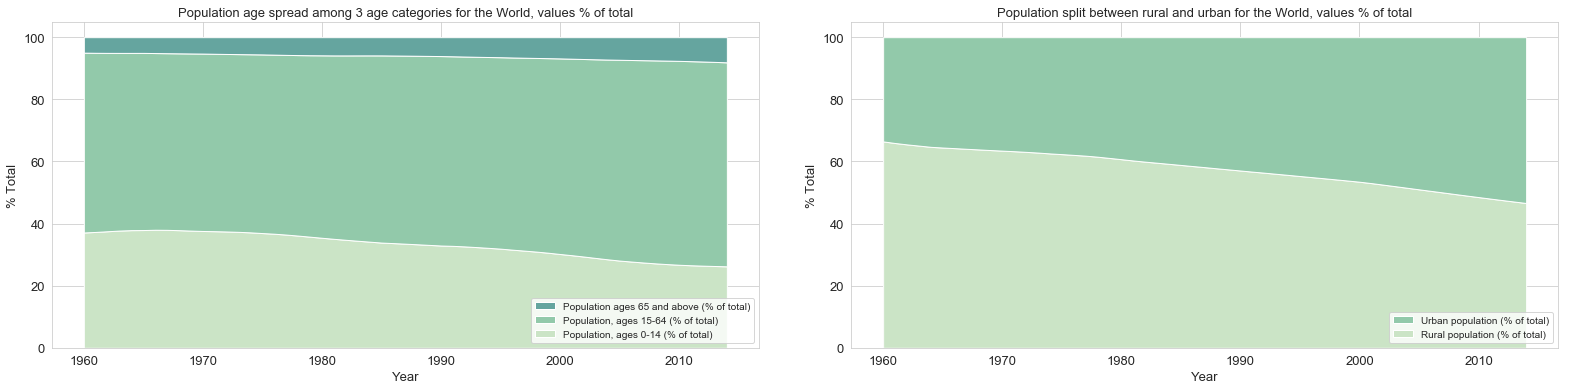

In [390]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (27,6),gridspec_kw={'wspace':0.13})

#Labels for our data
agelabels = ['Population, ages 0-14 (% of total)','Population, ages 15-64 (% of total)','Population ages 65 and above (% of total)']
#Creating the stackplot
axes[0].stackplot(xage,yage,labels=agelabels,colors=sns.cubehelix_palette(6, start=.5, rot=-.65))
#Setting graph title
axes[0].set_title('Population age spread among 3 age categories for the World, values % of total')
#Setting graph legend
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1],labels[::-1],loc=4)

#Labels for our data
loclabels = ['Rural population (% of total)', 'Urban population (% of total)']
#Creating the stackplot
axes[1].stackplot(xloc,yloc,labels=loclabels,colors=sns.cubehelix_palette(6, start=.5, rot=-.65))
#Setting graph title
axes[1].set_title('Population split between rural and urban for the World, values % of total')
#Setting graph legend
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1],labels[::-1],loc=4)

#Setting axis titles
for ax in axes:
    ax.set_xlabel('Year')
    ax.set_ylabel('% Total')

This result is unsurpising - the world is getting older, and more urbanised. It's interesting to see that so many people have moved from the countryside to the cities though.

I like the presentation of this data, I think the stackplot works well to give you a clear idea of how each category relates to the others in size, and how it changes over time.

# 3) How has the distribution of wealth changed?

To create my dataframe for this analysis I will select the indicators I want to use, and then use inner joins to condense the table and lign up the columns based on Year and Country. This is to prevent duplicating the year and country columns unnecessarily, allowing for easy manipulation, visualisation and reducing the memory requirements.

In [245]:
wealthdisparity = pd.read_sql(
    """

    SELECT  A.CountryName as 'Country Name', A.[Year], A.Value AS 'Income held by top 20%',
            B.Value AS 'Income held by bottom 20%',
            C.Value AS 'GINI Index'
            
    FROM indicators A
        
    INNER JOIN indicators B ON
    A.[Year] = B.[Year] AND A.CountryName = B.CountryName AND A.IndicatorName != B.IndicatorName
    
    INNER JOIN indicators C ON
    
    A.[Year] = C.[Year] AND A.CountryName = C.CountryName

    WHERE A.IndicatorName = 'Income share held by highest 20%' AND B.IndicatorName = 'Income share held by lowest 20%' AND C.IndicatorName = 'GINI index (World Bank estimate)'


    """,
    con=conn
)

In [14]:
wealthdisparity['Country Name'].unique()

array(['Australia', 'Brazil', 'Canada', 'China', 'Costa Rica', 'Ethiopia',
       'Thailand', 'Uruguay', 'Venezuela, RB', 'Bangladesh', 'India',
       'Indonesia', 'Malaysia', 'Mexico', 'Morocco', 'Nepal', 'Rwanda',
       'Botswana', "Cote d'Ivoire", 'Nigeria', 'Philippines', 'Poland',
       'Sri Lanka', 'Tunisia', 'Argentina', 'Dominican Republic',
       'Guatemala', 'Honduras', 'Iran, Islamic Rep.', 'Israel', 'Jordan',
       'Lesotho', 'United States', 'Chile', 'Ecuador', 'Ghana', 'Hungary',
       'Mauritania', 'Pakistan', 'Slovenia', 'Turkey', 'Belarus',
       'Colombia', 'Croatia', 'Czech Republic', 'Estonia', 'Jamaica',
       'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova',
       'Russian Federation', 'Slovak Republic', 'Trinidad and Tobago',
       'Turkmenistan', 'Ukraine', 'Uzbekistan', 'Bulgaria', 'Panama',
       'Romania', 'Uganda', 'Bolivia', 'Paraguay', 'El Salvador',
       'Guinea', 'Senegal', 'Tanzania', 'Zambia', 'Burundi',
       'Central Af

## Stage 1) Initial data preparation

These indexes do not include the continent-like combined values for the countries so I will need to condense the data down manually. The reason for doing so is covered in the Stage 2) discussion.

#### Step 1) Export the country list for our indicators to a csv file

In [15]:
pd.read_sql(
    """
    SELECT DISTINCT(CountryName)
    FROM indicators
    """,
    con=conn
).to_csv('CountryList.csv')

#### Step 2) Locate a datasource for a list of the countries in each continent

I will be using https://www.worldatlas.com/cntycont.htm

#### Step 3) Use VLOOKUP to match the values in the list from 2) to the list from 1)

Manually amend the discrepenancies in country name between Column C (which was a copy of Column B, the country names from website) and Column E (country names from our database). VLOOKUP in column F used to find discrepancies. See Countries.xlsx for the worksheet, a copy of which is saved as csv to reimport.

#### Step 4) Import the country list and select only columns wanted

In [246]:
countries = pd.read_csv('Countries.csv')
countries = countries[['Country List Grouped By Continent','Continent']]
countries.columns = ['Country','Continent']
#So now we have a list of each country and the respectice continent it belongs to
countries.head(3)

,Country,Continent
0,Algeria,Africa
1,Angola,Africa
2,Benin,Africa


In [247]:
#Pairing the countries with their continents
wealthdisparity['Continent'] = wealthdisparity['Country Name'].apply(lambda x: str(countries[countries['Country'] == x]['Continent'].values)[2:-2])

In [248]:
wealthdisparity.head(3)

,Country Name,Year,Income held by top 20%,Income held by bottom 20%,GINI Index,Continent
0,Australia,1981,39.17,7.67,31.33,Oceania
1,Brazil,1981,62.29,2.68,57.93,South America
2,Canada,1981,39.99,7.14,32.60,North America


In [249]:
#Are there any countires which have not been mapped?
wealthdisparity[wealthdisparity['Continent']=='']['Country Name'].unique()

array(['Kosovo', 'West Bank and Gaza'], dtype=object)

In [250]:
#Dropping these
wealthdisparity = wealthdisparity[wealthdisparity['Continent']!='']
#Checking none remaining
wealthdisparity[wealthdisparity['Continent']=='']['Country Name'].unique()

array([], dtype=object)

## Stage 2) Planning my data visualisation

My original plan for these indexes was to plot the relationship of 'Income held by top 20%' vs 'Income held by bottom 20%' for each country for each year, and label the start and end points to see how the relationship has changed over time. However, upon plotting this I observed a number of problems:

1. It's a mess! Although it shows a clear relationship, you can't interpret anything about any individual country from the below
-  Not all countries have the same amount of data present, at the same intervals, or over the same timespans. This leads to incomplete lines and adds to the messy appearance

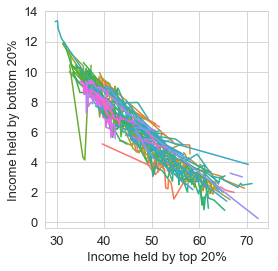

In [391]:
plt.figure(figsize=(4,4))
sns.lineplot(x='Income held by top 20%',y='Income held by bottom 20%',hue='Country Name',legend=False,data=wealthdisparity)

To overcome these problems I am going to collapse the data down to aggregate the values by continent, however in order to retain some depth of the data I am going to plot the mean, max and min for each index for continent per year. This allows us to see how disparate the values are across the whole continent. To present this in an intuitive and interesting manner the difference between max and mean, and min and mean, will be represented as a shaded area for each continent.

To do this I am going to leverage the functionality of the Matplotlib stackplot: https://matplotlib.org/examples/pylab_examples/stackplot_demo.html
The values for the mean and max for the stackplot will be calculated as mean-min and max-(mean-min)-min respectively. By converting them to delta values their true magnitude is represented, and the area for the min will be set to transparent. See below for an example:

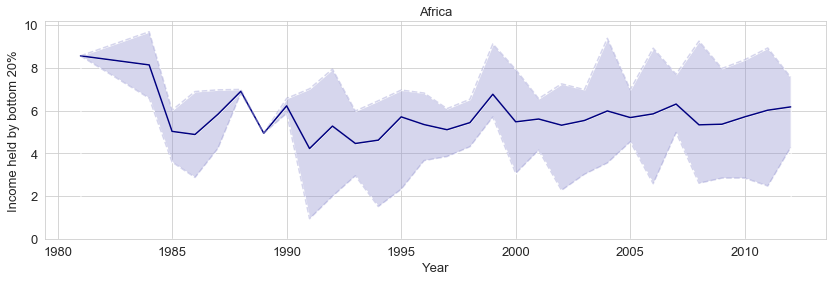

In [392]:
#Calculation of these variables and what they are is covered in the method to follow
fig, axes = plt.subplots(figsize=(14,4))
axes.stackplot(wealthmean[wealthmean['Continent']=='Africa']['Year'],delta_dict['Africa']['Income held by bottom 20%'],colors=[[1,1,1,0],[0.54,0.54,0.80078431, 0.35],[0.54,0.54,0.80078431, 0.35]])
for table in [wealthmean,wealthmax,wealthmin]:
    sns.lineplot(table[table['Continent']=='Africa']['Year'],table[table['Continent']=='Africa']['Income held by bottom 20%'],ax=axes)

axes.set_title('Africa')
plt.setp(axes.lines[1:],ls='--')
plt.setp(axes.lines[0],c=(sns.light_palette("navy")[5]))
plt.show()

For consistencies' sake I would like to use the same palette as the last question, however because we are going to be having overlapping areas whose edges need to remain distinct, the previous palette's shades are too similar. As such I'm going to select a palette with a little more divergence.

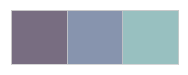

In [395]:
wealth_palette = []
#Selecting the colours we want from the generated palette
for i in range(0,5,2):
    wealth_palette.append(sns.cubehelix_palette(8, start=.5, rot=-.65, reverse=True)[i])
#Setting alpha value
for i in wealth_palette:
    i.append(0.65)
    
sns.palplot(wealth_palette)

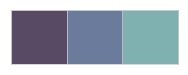

In [396]:
#Same colour values but slightly increased alpha to make graph lines more distinct
wealth_palette_lines = wealth_palette
for i in wealth_palette_lines:
    i[-1] = 0.8
    
sns.palplot(wealth_palette_lines)

## Stage 3) Manipulating the data to a graph-able format

#### Step 1) Creating our mean, max and min tables

In [251]:
#Creating mean table
wealthmean = wealthdisparity.groupby(['Year','Continent'],as_index=False).mean()
wealthmean['Type'] = 'Mean'
wealthmean.head(3)

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.31,8.560,32.420,Mean
1,1981,Asia,44.67,7.050,37.165,Mean
2,1981,North America,45.69,5.245,40.045,Mean


In [252]:
#Creating max table
wealthmax = wealthdisparity.groupby(['Year','Continent'],as_index=False).max().drop('Country Name',axis=1)
wealthmax['Type'] = 'Max'
wealthmax.head(3)

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.31,8.56,32.42,Max
1,1981,Asia,51.40,8.68,45.22,Max
2,1981,North America,51.39,7.14,47.49,Max


In [253]:
#Creating min table
wealthmin = wealthdisparity.groupby(['Year','Continent'],as_index=False).min().drop('Country Name',axis=1)
wealthmin['Type'] = 'Min'
wealthmin.head(3)

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.31,8.56,32.42,Min
1,1981,Asia,37.94,5.42,29.11,Min
2,1981,North America,39.99,3.35,32.60,Min


#### Step 2) Creating a dictionary to hold all of our sub-divided data to iterate through and create the graphs

In [254]:
index_dict = {}

#Iterating through continents to create dictionary value for each continent key
for cont in wealthmean['Continent'].unique():    
    index_dict[cont] = {}
    
    #Iterating through indexes for each continent
    for c in wealthmean.columns[2:-1]:          
        #This creates a dictionary containing keys for each index, which have keys for each continent, whose values are a 3 x M array of the min, mean and max values
        index_dict[cont][c] = np.vstack([[i[i['Continent']==cont][c] for i in [wealthmin,wealthmean,wealthmax]]])
        
#This dictionary should allow us to iterate through the values and make graphing much simpler  

In [255]:
#Pulling an example key
index_dict['Africa']['Income held by top 20%']

array([[41.31      , 38.92      , 45.01      , 45.44      , 42.67      ,
        43.38      , 49.92      , 46.3       , 42.96      , 41.63      ,
        45.76      , 48.33      , 42.62      , 46.46      , 46.04      ,
        46.17      , 39.4       , 40.18      , 46.5       , 43.15      ,
        46.04      , 39.32      , 44.66      , 42.88      , 43.49      ,
        40.32      , 41.3       , 39.49      , 40.8       , 41.5       ],
       [41.31      , 42.535     , 51.1875    , 52.715     , 46.29666667,
        43.645     , 49.92      , 46.315     , 51.854     , 50.81      ,
        55.53428571, 54.99625   , 50.37      , 51.85      , 56.27666667,
        50.15285714, 45.795     , 50.98444444, 51.09      , 51.87222222,
        50.94375   , 50.85666667, 50.058     , 51.63714286, 47.59      ,
        51.83714286, 52.395     , 50.92666667, 49.12      , 46.704     ],
       [41.31      , 46.15      , 58.88      , 59.99      , 48.65      ,
        43.91      , 49.92      , 46.33      , 61

#### Step 3) Converting our array values to delta values
The values for the mean and max for the stackplot will be calculated as mean-min and max-(mean-min)-min respectively.

In [256]:
#Creating a copy of the dictionary made earlier
delta_dict = index_dict

#Iterating through the continents
for cont in delta_dict:
    
    #Iterating through the indicators for each continent
    for index in delta_dict[cont]:
        #Mean = Mean - Min i.e. delta value
        delta_dict[cont][index][1] = delta_dict[cont][index][1]-delta_dict[cont][index][0]
        #Mean = Mean - (Mean-Min) - Min i.e. delta value
        delta_dict[cont][index][2] = delta_dict[cont][index][2] - delta_dict[cont][index][1] - delta_dict[cont][index][0]

In [257]:
#Pulling an example key
delta_dict['Africa']['Income held by top 20%']
#Values seem to be correct!

array([[4.13100000e+01, 3.89200000e+01, 4.50100000e+01, 4.54400000e+01,
        4.26700000e+01, 4.33800000e+01, 4.99200000e+01, 4.63000000e+01,
        4.29600000e+01, 4.16300000e+01, 4.57600000e+01, 4.83300000e+01,
        4.26200000e+01, 4.64600000e+01, 4.60400000e+01, 4.61700000e+01,
        3.94000000e+01, 4.01800000e+01, 4.65000000e+01, 4.31500000e+01,
        4.60400000e+01, 3.93200000e+01, 4.46600000e+01, 4.28800000e+01,
        4.34900000e+01, 4.03200000e+01, 4.13000000e+01, 3.94900000e+01,
        4.08000000e+01, 4.15000000e+01],
       [0.00000000e+00, 3.61500000e+00, 6.17750000e+00, 7.27500000e+00,
        3.62666667e+00, 2.65000000e-01, 0.00000000e+00, 1.50000000e-02,
        8.89400000e+00, 9.18000000e+00, 9.77428571e+00, 6.66625000e+00,
        7.75000000e+00, 5.39000000e+00, 1.02366667e+01, 3.98285714e+00,
        6.39500000e+00, 1.08044444e+01, 4.59000000e+00, 8.72222222e+00,
        4.90375000e+00, 1.15366667e+01, 5.39800000e+00, 8.75714286e+00,
        4.10000000e+00,

## Stage 4) Plotting the data!

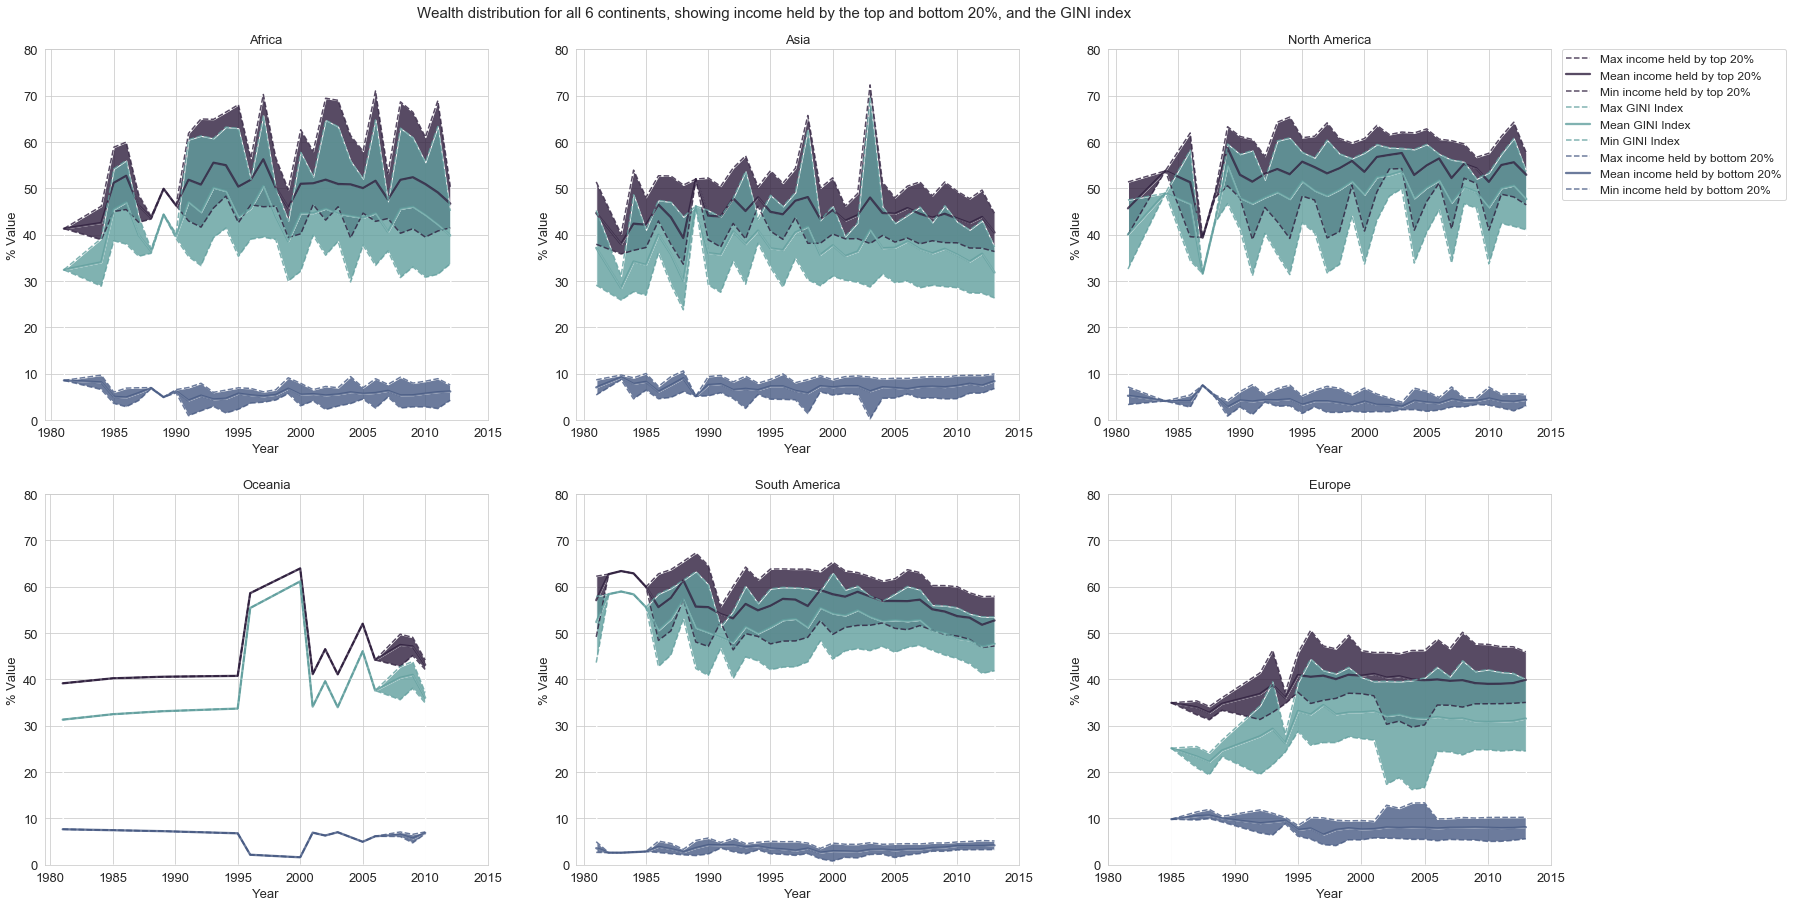

In [422]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(27,15))
#Variable for iterative indexing
ind = -1

for cont in list(delta_dict.keys()):
    ind +=1
    #Variable to select common colours for each graph
    colour =-1
    for index in delta_dict[cont]:      
        colour += 1
        #Stack plot - Year values for each continent as the x, delta indicator values for the y
        axes[int((1/3)*ind)][ind-3].stackplot(wealthmean[wealthmean['Continent']==cont]['Year'],delta_dict[cont][index],colors=[[1,1,1,0],list(wealth_palette[colour]),list(wealth_palette[colour])])
        #Setting graph title for each graph
        axes[int((1/3)*ind)][ind-3].set_title(cont)
        #Plotting linegraphs for mean, max and min on top of the stack plots to improve visuals
        for table in [wealthmean,wealthmax,wealthmin]:
            sns.lineplot(table[table['Continent']==cont]['Year'],table[table['Continent']==cont][index],label=index,ax=axes[int((1/3)*ind)][ind-3])
        #Setting y label for each graph        
        axes[int((1/3)*ind)][ind-3].set_ylabel('% Value')     
            
    #Matching colour lines in linegraphs to those in stackplot and boldening the lines
    for i in range(0,7,3):
        plt.setp(axes[int((1/3)*ind)][ind-3].lines[i],c=wealth_palette_lines[int(i/3)])
        plt.setp(axes[int((1/3)*ind)][ind-3].lines[i],lw=2.3)
     
    #Setting linestyle for max and min values to dashed lines
    for i in [1,2,4,5,7,8]:
        plt.setp(axes[int((1/3)*ind)][ind-3].lines[i],ls='--')
        
    #Removing legend
    axes[int((1/3)*ind)][ind-3].get_legend().remove()
    
    #Setting common y&x axes to allow easier comparison between each continent
    axes[int((1/3)*ind)][ind-3].set_yticks(range(0,90,10))
    axes[int((1/3)*ind)][ind-3].set_xticks(range(1980,2020,5))
        
#Creating common legend
handles, labels = axes[0][1].get_legend_handles_labels()
#Creating custom legend labels
labels = ['Max income held by top 20%','Mean income held by top 20%','Min income held by top 20%','Max GINI Index','Mean GINI Index','Min GINI Index','Max income held by bottom 20%','Mean income held by bottom 20%','Min income held by bottom 20%']
#Reordering legend handles
handles = [handles[i] for i in [1,0,2,7,6,8,4,3,5]]
axes[0][2].legend(handles,labels,bbox_to_anchor=(1.01, 1.017),fontsize=12)
fig.suptitle('Wealth distribution for all 6 continents, showing income held by the top and bottom 20%, and the GINI index',y=0.92, fontsize=15)

plt.show()

This was my favourite indicator to investigate, mainly for all the challenges I had to figure out solutions for:

1. Creating the inner join statement to select the data we want and align it on the right columns
-  Mapping each country to it's continent, and figuring out how to find the discrepancies between the online list I was using and the country list used in this database
- Splitting the data from our wealthmean,max and min tables and putting this in one orgranised dictionary to make the iteration through it simpler
- Finally, working on the data presentation - figuring out a good colour scheme, and a way to highlight and differentiate the mean and max&min lines

I'm really happy with the result for this, and I think I've produced an awesome set of graphs!

# 4) How have literacy rates changed?

As this dataset only has records for 3 decades for our two indicators I will using a diverging bar diagram to present this data, stacking the data for each decade on top of one another.

As we're only comparing 3 values, I will use the same palette as for question 2) to maintain consistenancy.

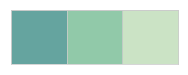

In [398]:
sns.palplot(sns.cubehelix_palette(6, start=.5, rot=-.65)[:3][::-1])

In [187]:
lit_rate = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SE.ADT.1524.LT.ZS',
        'SE.ADT.LITR.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') 
        
    
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [28]:
lit_rate.head(3)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,East Asia & Pacific (all income levels),EAS,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,1990,94.056498
1,Latin America & Caribbean (all income levels),LCN,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,1990,93.534741
2,Middle East & North Africa (all income levels),MEA,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,1990,77.516740


In [148]:
#Do we have any missing values?
lit_rate.groupby(['CountryName','IndicatorName']).count()['Year']

CountryName                                     IndicatorName                                              
East Asia & Pacific (all income levels)         Adult literacy rate, population 15+ years, both sexes (%)      3
                                                Youth literacy rate, population 15-24 years, both sexes (%)    3
European Union                                  Adult literacy rate, population 15+ years, both sexes (%)      2
                                                Youth literacy rate, population 15-24 years, both sexes (%)    2
Latin America & Caribbean (all income levels)   Adult literacy rate, population 15+ years, both sexes (%)      3
                                                Youth literacy rate, population 15-24 years, both sexes (%)    3
Middle East & North Africa (all income levels)  Adult literacy rate, population 15+ years, both sexes (%)      3
                                                Youth literacy rate, population 15-24 years, both sex

In [150]:
#Europe is missing one set of values, which are these?
lit_rate[lit_rate['CountryCode']=='EUU']['Year'].unique()

array([2000, 2010], dtype=int64)

In [188]:
#Inserting 0 values for Europe so that the graphing is correct.
lit_rate = lit_rate.append(lit_rate[lit_rate['CountryCode']=='EUU'].iloc[:2,:-2].join(pd.DataFrame(data=[[1990,0],[1990,0]],columns=['Year','Value'],index=[11,17])))
lit_rate.tail(3)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
33,World,WLD,"Adult literacy rate, population 15+ years, bot...",SE.ADT.LITR.ZS,2010,85.20098
11,European Union,EUU,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,1990,0.00000
17,European Union,EUU,"Adult literacy rate, population 15+ years, bot...",SE.ADT.LITR.ZS,1990,0.00000


In [191]:
#Re-sorting values
lit_rate = lit_rate.sort_values(['IndicatorName','Year','CountryName'])

In [198]:
#Neatening up country names
lit_rate['CountryName'] = lit_rate['CountryName'].apply(lambda x: x.replace(' (all income levels)',''))

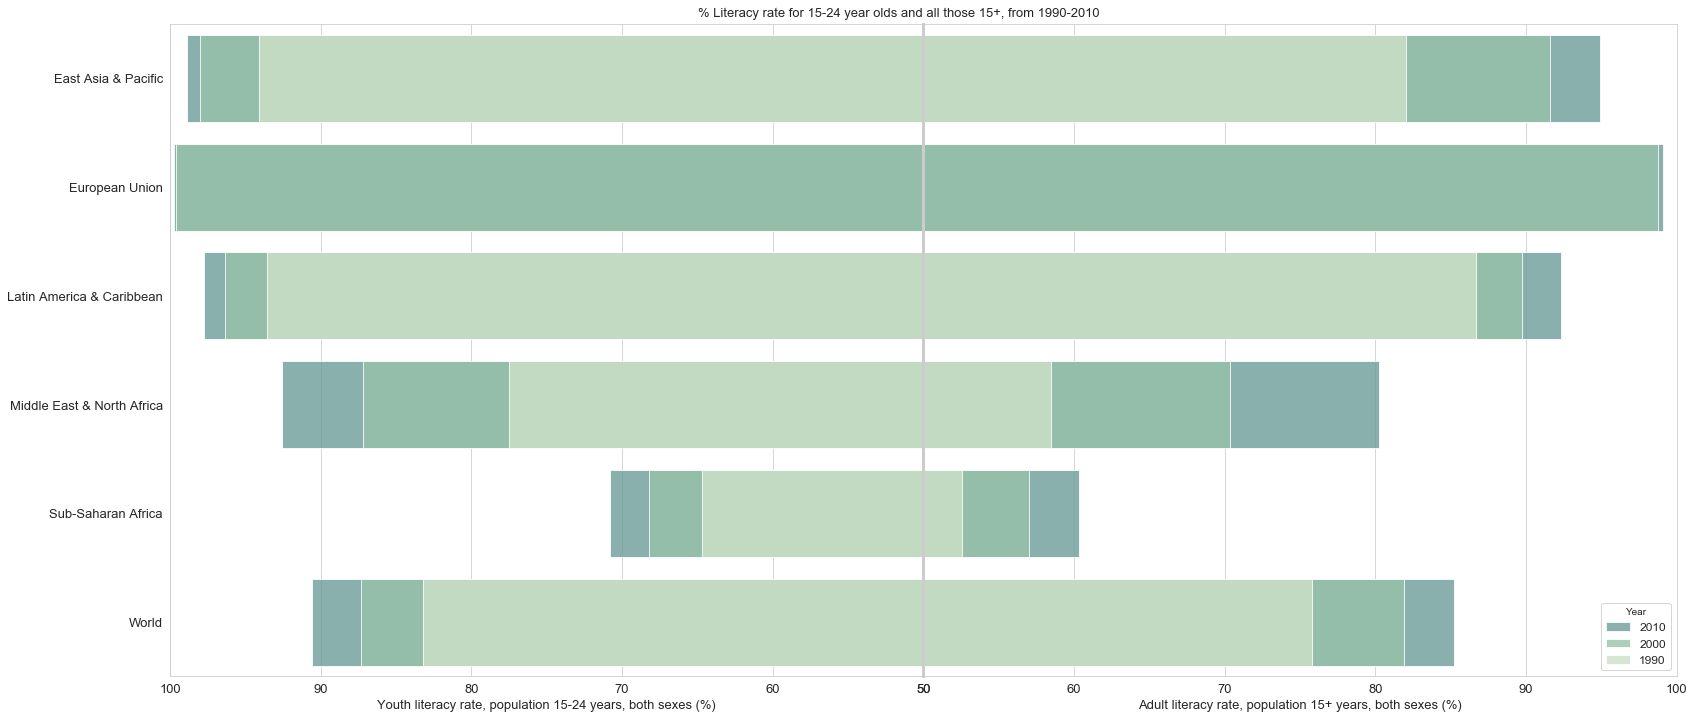

In [405]:
fig, axes = plt.subplots(ncols=2, figsize = (27,12),gridspec_kw={'wspace':0.0},sharey=True)

#Iterating through the indicators
for index in lit_rate['IndicatorName'].unique():
    
    #Variable index value equaling 0 or 1 depending on the index
    ind = int(len('Adult literacy rate, population 15+ years, both sexes (%)')/len(index))
    #Variable to select colour
    colour=-1
    #Creating sub-table to select individual indicators values
    table = lit_rate[lit_rate['IndicatorName']==index]
    #Iterating through the years to create seperate bars for each
    for year in lit_rate['Year'].unique()[::-1]:
        colour+=1
        ytable = table[table['Year']==year]
        sns.barplot(x='Value',y='CountryName',data=ytable,palette = [[i]*6 for i in sns.cubehelix_palette(6, start=.5, rot=-.65)[:3][::-1]][colour],ax=axes[ind], label=year)
    #Setting axis labels
    axes[ind].set_ylabel('')
    axes[ind].set_xlabel(index, fontsize=13)
    #For some strange reason, Seaborn doesn't pull the alpha value for the palette when making the bar patches. Manually amending the alpha value.
    for p in axes[ind].patches:
        plt.setp(p,alpha=.80)

#Setting axes limits
axes[0].set_xlim(100,50)
axes[1].set_xlim(50,100)
#Setting central axis to be thicker
axes[1].spines['left'].set_linewidth(3)
#Setting legend and diagram title
axes[1].legend(loc="lower right",title='Year', fontsize=12, frameon=True)
fig.suptitle('% Literacy rate for 15-24 year olds and all those 15+, from 1990-2010',y=0.9, fontsize=13)

plt.show()

This is an interesting result - I was aware that the world was becoming more literate, but the amount of increase over 2 decades for the Middle East & North Africa is quite astonishing! It's odd that there's no data for North America, but for whatever reason it's not in the database.

I like the presentation of this data, I feel it's a good way to show the difference in literacy rate between the two age groups; e.g. the pronounced difference in values for Sub-Saharan Africa is easily identifiable. I think it gives the viewer a good insight in to the trends for each area in education over the two decades.

## 5) How has the health of the world changed?

For this analysis I'm going to be collapsing 2 different groups of indexes in to a single value:

The below will be collapsed in to a single index - 'Average physicians, nurses and hospital beds (per 1,000 people)' - this is to condense data that presents very similar information - access to healthcare, and also to get the most amount of data for this information as not every measure has been recorded for each area each year.
- Hospital beds (per 1,000 people)
- Nurses and midwives (per 1,000 people)
- Physicians (per 1,000 people)

The below will be collapsed in to a single index - 'Smoking prevalence (% of adults)' - again, condensing data that provides very similar information, and allows us to create a single graph to show smoking prevalence.
- Smoking prevalence, females (% of adults)
- Smoking prevalence, males (% of adults)


In [429]:
health = pd.read_sql(
    """
    SELECT CountryName,CountryCode,'Average physicians, nurses and hospital beds (per 1,000 people)'  as IndicatorName,'SH.MED.PNHB.ZS' as IndicatorCode,Year,AVG(Value) as Value FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.MED.BEDS.ZS',
        'SH.MED.NUMW.P3',
        'SH.MED.PHYS.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    GROUP BY CountryName,Year
    UNION ALL
    SELECT CountryName,CountryCode,'Smoking prevalence (% of adults)'  as IndicatorName,'SH.PRV.SMOK.AD' as IndicatorCode,Year,AVG(Value) as Value FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.PRV.SMOK.FE',
        'SH.PRV.SMOK.MA') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    GROUP BY CountryName,Year    
    UNION ALL
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.STA.MALN.ZS',
        'SH.STA.OWGH.ZS',
        'SH.XPD.TOTL.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [430]:
#Seperating our health dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
health_dict = {}
for i in health.IndicatorCode.unique():
    health_dict[i] = health[health.IndicatorCode == i]

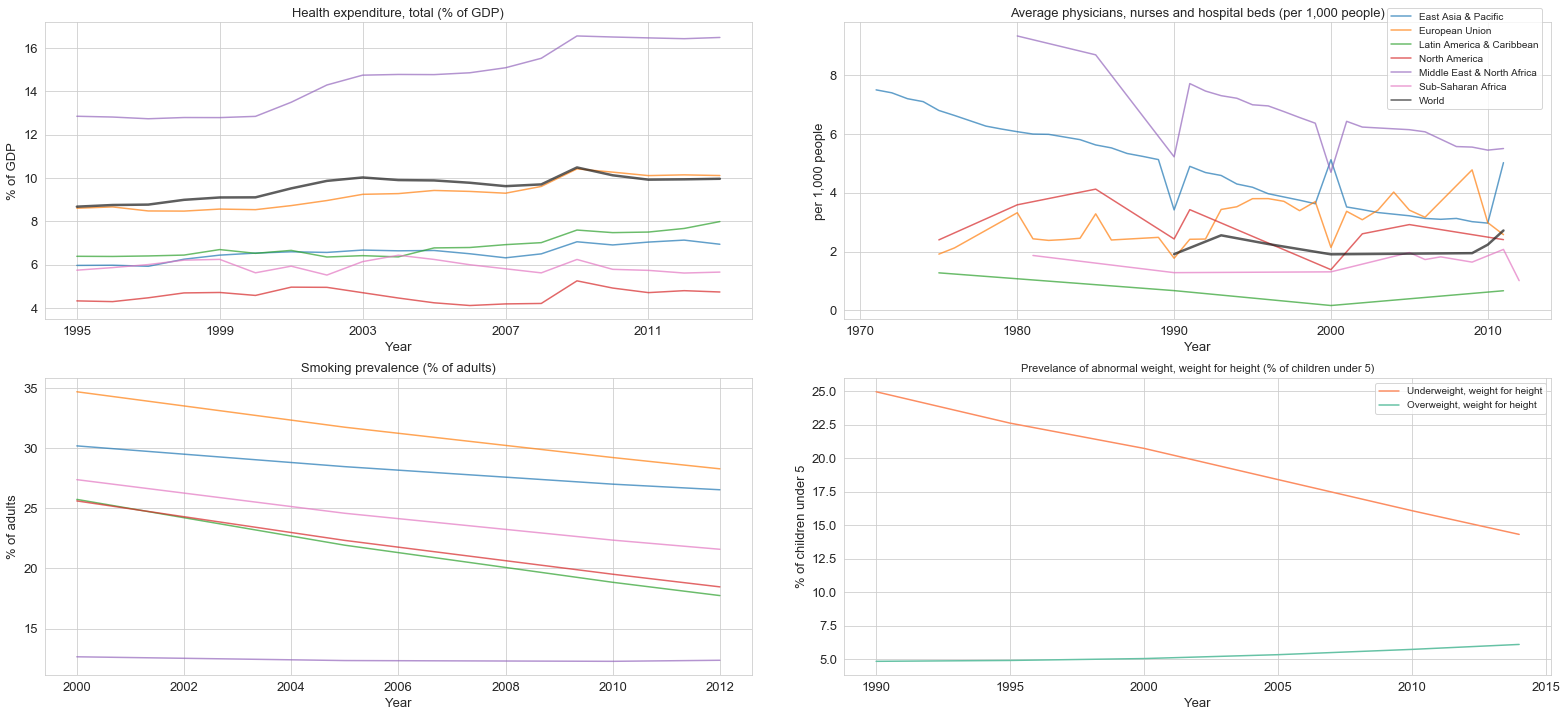

In [431]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
#As the final graph only contains world values, using custom list of IndicatorCodes to order the graphs correctly
for i in ['SH.XPD.TOTL.ZS','SH.MED.PNHB.ZS','SH.PRV.SMOK.AD','SH.STA.OWGH.ZS','SH.STA.MALN.ZS']:
    ind +=1
    if ind < 2:
        #First row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=health_dict[i],ax=axes[0][ind],palette=palette)
        #Pulling title from IndicatorName field
        axes[0][ind].set_title(str(health_dict[i]['IndicatorName'].unique())[2:-2])
        #Removing legend to allow for a single common legend
        axes[0][ind].get_legend().remove()
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[0][ind].lines:
            plt.setp(l,alpha=.70)
        
    elif ind == 2:
        #Bottom left graph
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=health_dict[i],ax=axes[1][ind-2])
        #Pulling title from IndicatorName field
        axes[1][ind-2].set_title(str(health_dict[i]['IndicatorName'].unique())[2:-2])
        #Removing legend to allow for a single common legend
        axes[1][ind-2].get_legend().remove()
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-2].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-2].lines:
            plt.setp(l,alpha=.70)

    elif ind < 5:
        #Bottom right graph, plotting the underweight and overweight values on the same graph
        sns.lineplot(x='Year',y='Value',data=health_dict[i],label=['Overweight, weight for height','Underweight, weight for height'][ind-3],color=sns.color_palette("Set2", 2)[ind-3],ax=axes[1][1])
        #Setting bottom right graph title
        axes[1][1].set_title('Prevelance of abnormal weight, weight for height (% of children under 5)',fontsize=11)
        #Creating the legend for bottom right axis, reversing order to match order of lines
        handles, labels = axes[1][1].get_legend_handles_labels()
        axes[1][1].legend(handles[::-1],labels[::-1])
        
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][1].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting legend label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Adding the legend to top right graph
axes[0][1].legend(handles,labels, bbox_to_anchor=(0.76, 0.69))
#Setting unique y label values
axes[0][0].set_ylabel('% of GDP')
axes[0][1].set_ylabel('per 1,000 people')
axes[1][0].set_ylabel('% of adults')
axes[1][1].set_ylabel('% of children under 5')
#Setting x ticks for top left graph to replace decimal year values automatically generated
axes[0][0].set_xticks(range(1995,2015,4))

plt.show()

There are some interesting results from these graphs. 

The decrease in the number of average physicians, nurses and hospitals per 1,000 surprised me - it'd be interesting to know the reason why, is it because of increasing population size? Are health services becoming more efficient requiring fewer resources per person? 

It would be nice to have the presence of some more recent data for the smoking prevalence indicators - the trend seems to be fairly linear but it would be nice to see what the impact of the rise in e-cigarettes has had on these values.

The dramatic decrease in underweight children under 5 is a good reflection of the dramatic decreases in extreme poverty seen globally over the last few decades. 

The SQL statement to create the dataframe was fun to build, and was a good practice of utilising GROUP BY and UNION ALL to create one seamless table.

# Conclusion:

This was a really fun project completed over the course of a few days. I learnt a lot from working through it and it was nice to blend my skills in SQL, Pandas and Matplotlib/Seaborn in one workbook. 

I feel I made some interesting visualisations from the data and enjoyed devising different methods of presenting timeline data. I am looking forward to applying what I learnt here in my next project!

## Extras!

This was a quick experiment I did to test representing the 'Value' dimension as the size of the points on the graph. However, as the values in this dataset are all quite close together it does not really work very well, as the sizes of the points are not that distinct from one another and thus you can't gain much information from it.

In [409]:
lifespan = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SP.DYN.AMRT.FE',
        'SP.DYN.AMRT.MA',
        'SP.DYN.TO65.FE.ZS',
        'SP.DYN.TO65.MA.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [410]:
lifespan_dict = {}
for i in lifespan.IndicatorCode.unique():
    lifespan_dict[i] = lifespan[lifespan.IndicatorCode == i]

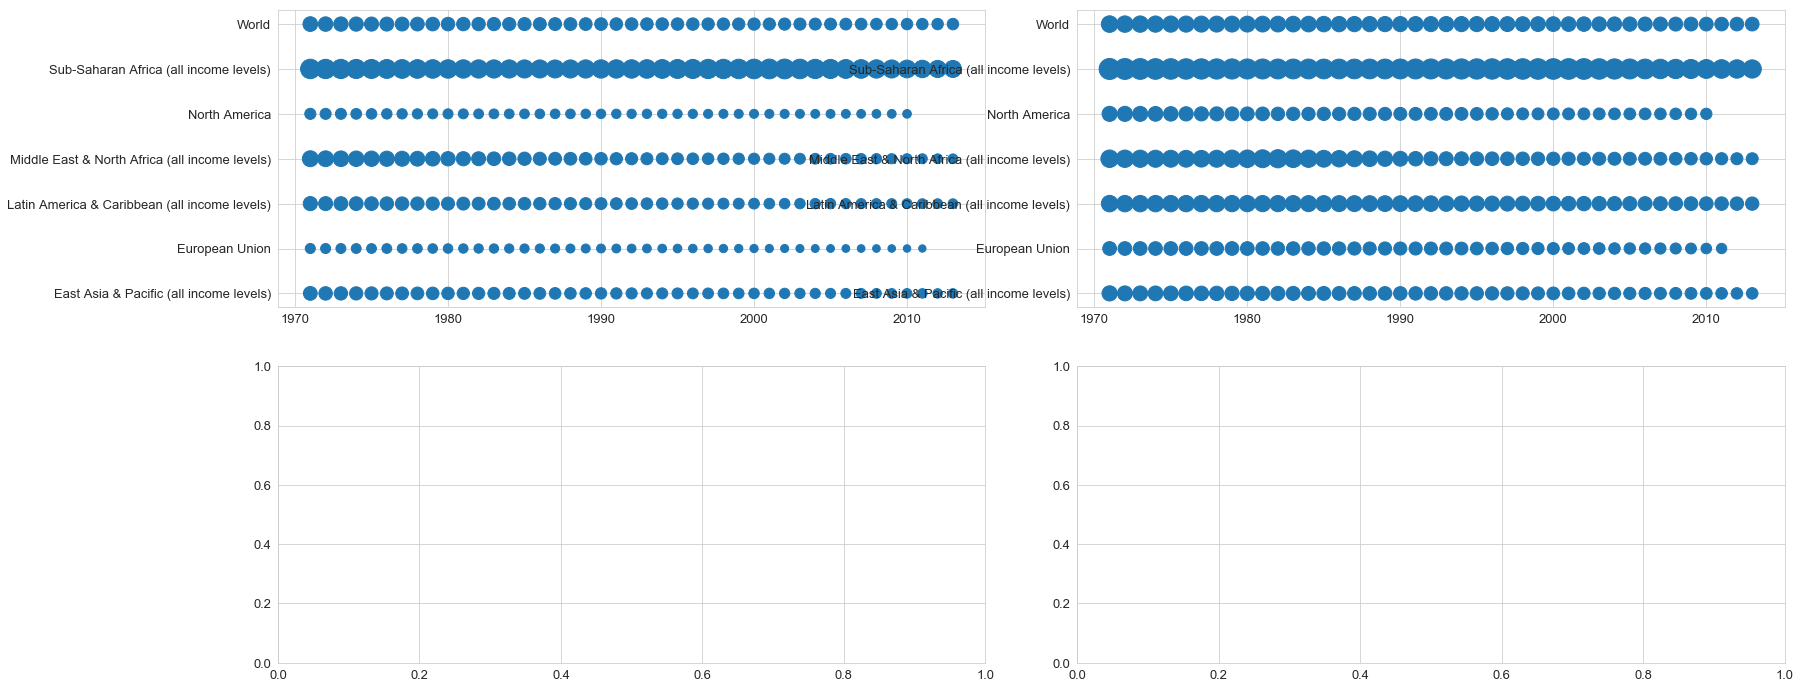

In [417]:

#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in lifespan.IndicatorCode.unique():
    ind +=1
    if ind < 2:
        #First row of graphs
        axes[0][ind].scatter(x='Year',y='CountryName',data=lifespan_dict[i],s='Value')


    else:
        break
        

plt.show()

## How has electricity consumption and production changed over the last 4 decades?

This was originally going to be my 2nd question, but as the purpose of this exercise was to practice and further data manipulation and visualisation, (and this did not represent a new method as it is similar to my 1st question), I decided to leave it out of the main report.
I kept it in as an extra as the data itself is fairly interesting to look at.

In [406]:
#Creating our subset of the data, selecting interesting indicators and these regions of the globe: 
#'East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World'
electricity = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN ('EG.ELC.FOSL.ZS',
            'EG.ELC.HYRO.ZS',
            'EG.ELC.NUCL.ZS',
            'EG.ELC.RNWX.ZS',
            'EG.FEC.RNEW.ZS',
            'EG.USE.COMM.FO.ZS',
            'EG.USE.ELEC.KH.PC') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [407]:
#Seperating our electricity dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
electricity_dict = {}
for i in electricity.IndicatorCode.unique():
    electricity_dict[i] = electricity[electricity.IndicatorCode == i]

Text(0,0.5,'kWh per capita')

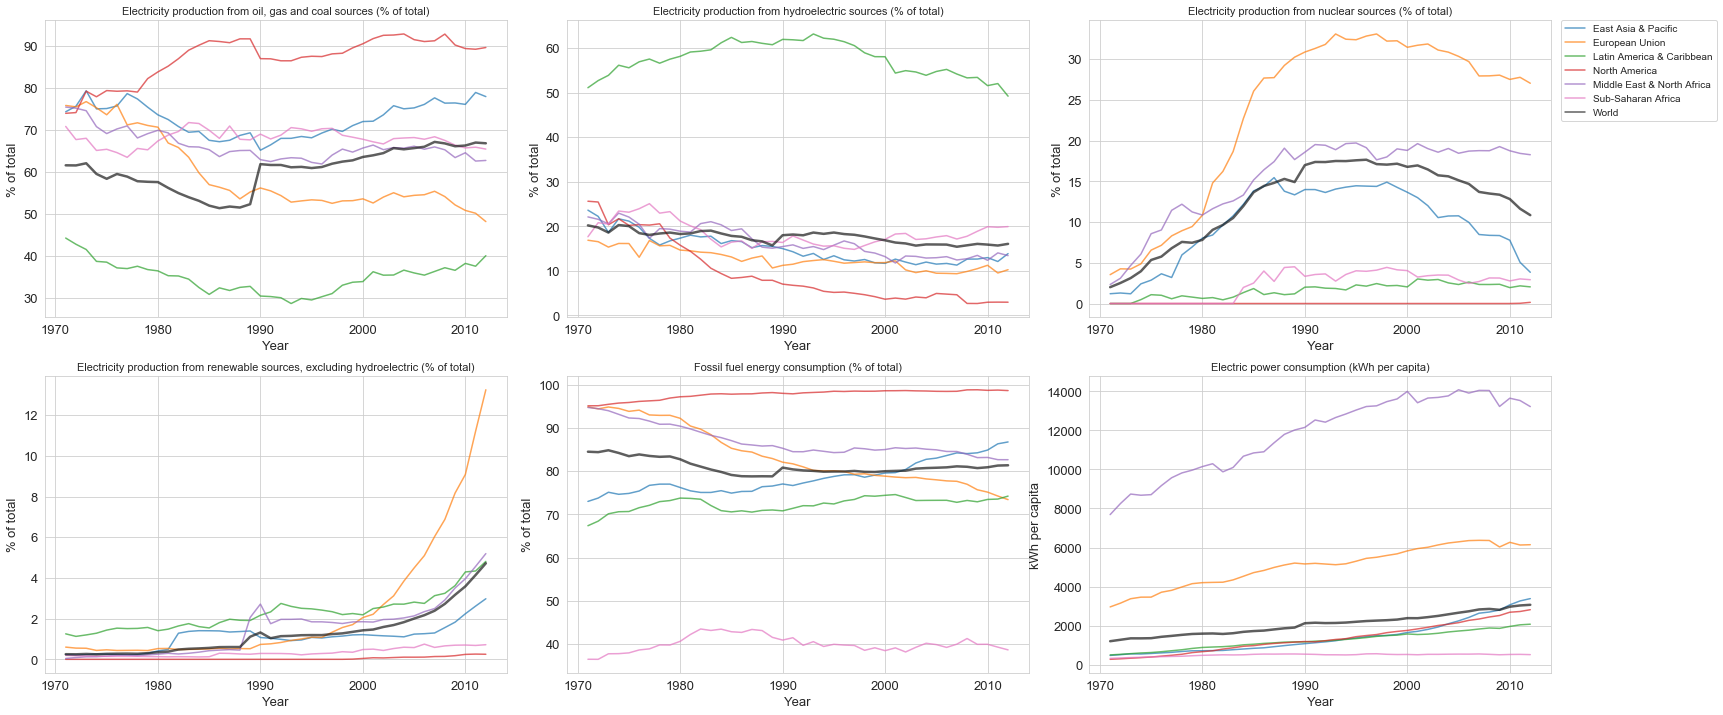

In [408]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in electricity.IndicatorCode.unique():
    ind +=1
    if ind < 3:
        #First row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=electricity_dict[i],ax=axes[0][ind])
        #Pulling title from IndicatorName field
        axes[0][ind].set_title(str(electricity_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[0][ind].get_legend().remove()
        #Setting y labels for graphs
        axes[0][ind].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[0][ind].lines:
            plt.setp(l,alpha=.70)
        
    elif ind < 6:
        #Second row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=electricity_dict[i],ax=axes[1][ind-3])
        #Pulling title from IndicatorName field
        axes[1][ind-3].set_title(str(electricity_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[1][ind-3].get_legend().remove()
        #Setting y labels for graphs    
        axes[1][ind-3].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-3].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-3].lines:
            plt.setp(l,alpha=.70)
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][2].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Setting legend position on graph
axes[0][2].legend(handles,labels,bbox_to_anchor=(1.01, 1.017))
#Setting unique y label value
axes[1][2].set_ylabel('kWh per capita')